In [18]:
# Core libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

# Optional: nicer plots
sns.set(style="whitegrid")

# Add src folder to Python path
sys.path.append(os.path.abspath(".."))

# Import your project modules
from src.data_loader import load_expenses
from src.analyzer import total_spent, spent_by_category, spent_by_month
from src.visualizer import plot_category, plot_over_time


In [19]:
# Path to your CSV (relative to notebook)
csv_path = "../data/expenses.csv"

# Load dataset
df = load_expenses(csv_path)

# Quick check
df.head()


,transaction id,date,time,type,name,emoji,category,amount,currency,local amount,local currency,notes and #tags,address,receipt,description,category split,money out,money in,amount
0,tx_0000ApdVsZLoVUe8OEPLyD,2025-01-01,11:10:53,Card payment,Tesco,🍏,Groceries,-1.45,GBP,-1.45,GBP,NaN,186-188 Southwark Park Road,NaN,TESCO-STORES 6070 BERMONDSEY GBR,NaN,-1.45,NaN,1.45
1,tx_0000ApdoR7T1y4SZkoPBZ4,2025-01-01,14:38:49,Monzo.me / Top-up,NaN,NaN,General,52.94,GBP,52.94,GBP,Internal transfer,NaN,NaN,Apurv Renake,NaN,NaN,52.94,52.94
2,tx_0000ApdqD2lmptyegKXmHh,2025-01-01,14:58:41,Pot transfer,Holiday Pot,NaN,Savings,15.00,GBP,15.00,GBP,NaN,NaN,NaN,NaN,NaN,NaN,15.00,15.00
3,tx_0000ApdqZcWGbHJoZFjn0L,2025-01-01,15:02:46,Card payment,British Gas,🇬🇧💨,Bills,-73.00,GBP,-73.00,GBP,NaN,Maidenhead Road,NaN,BRITISH GAS ENERGY WINDSOR GBR,NaN,-73.00,NaN,73.00
4,tx_0000ApdsZkrzklGlcZlvpB,2025-01-01,15:25:12,Pot transfer,Holiday Pot,NaN,Savings,10.00,GBP,10.00,GBP,NaN,NaN,NaN,NaN,NaN,NaN,10.00,10.00


In [11]:
# Basic info
df.info()

# Quick stats
df.describe()

# Check unique categories
df['category'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   transaction id   1087 non-null   object        
 1   date             1087 non-null   datetime64[ns]
 2   time             1087 non-null   object        
 3   type             1087 non-null   object        
 4   name             1011 non-null   object        
 5   emoji            757 non-null    object        
 6   category         1087 non-null   object        
 7   amount           1087 non-null   float64       
 8   currency         1087 non-null   object        
 9   local amount     1087 non-null   float64       
 10  local currency   1087 non-null   object        
 11  notes and #tags  244 non-null    object        
 12  address          700 non-null    object        
 13  receipt          0 non-null      float64       
 14  description      934 non-null    object 

array(['Groceries', 'General', 'Savings', 'Bills', 'Shopping',
       'Transport', 'Eating out', 'Transfers', 'Personal care', 'Income',
       'Rent', 'Gifts', 'Expenses', 'Entertainment', 'Family', 'Holidays',
       'Finances'], dtype=object)

In [20]:
# Info about dataframe
df.info()

# Summary stats for numeric columns
df.describe()

# Check unique categories
df['category'].unique()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1087 entries, 0 to 1086
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   transaction id   1087 non-null   object        
 1   date             1087 non-null   datetime64[ns]
 2   time             1087 non-null   object        
 3   type             1087 non-null   object        
 4   name             1011 non-null   object        
 5   emoji            757 non-null    object        
 6   category         1087 non-null   object        
 7   amount           1087 non-null   float64       
 8   currency         1087 non-null   object        
 9   local amount     1087 non-null   float64       
 10  local currency   1087 non-null   object        
 11  notes and #tags  244 non-null    object        
 12  address          700 non-null    object        
 13  receipt          0 non-null      float64       
 14  description      934 non-null    object 

array(['Groceries', 'General', 'Savings', 'Bills', 'Shopping',
       'Transport', 'Eating out', 'Transfers', 'Personal care', 'Income',
       'Rent', 'Gifts', 'Expenses', 'Entertainment', 'Family', 'Holidays',
       'Finances'], dtype=object)

In [29]:
# Remove duplicate columns (keep the last one)
df = df.loc[:, ~df.columns.duplicated()]

# Confirm column names
print(df.columns)


Index(['transaction id', 'date', 'time', 'type', 'name', 'emoji', 'category',
       'amount', 'currency', 'local amount', 'local currency',
       'notes and #tags', 'address', 'receipt', 'description',
       'category split', 'money out', 'money in'],
      dtype='object')


In [32]:
# Use Money Out / Money In if available
if 'money out' in df.columns and 'money in' in df.columns:
    df['amount'] = df['money in'].fillna(0) + df['money out'].fillna(0)  # ADD, not subtract
elif 'amount' in df.columns:
    df['amount'] = df['amount']
else:
    raise ValueError("No valid column found for amount")

# Ensure numeric
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df = df.dropna(subset=['amount'])

# Fill missing categories
df['category'] = df['category'].fillna("General")

# Quick check
df[['date','category','amount']].head()


,date,category,amount
0,2025-01-01,Groceries,-1.45
1,2025-01-01,General,52.94
2,2025-01-01,Savings,15.00
3,2025-01-01,Bills,-73.00
4,2025-01-01,Savings,10.00


In [33]:
total_expenses = df[df['amount'] < 0]['amount'].abs().sum()
total_income = df[df['amount'] > 0]['amount'].sum()

print(f"Total expenses in 2025: £{total_expenses:,.2f}")
print(f"Total income in 2025: £{total_income:,.2f}")


Total expenses in 2025: £33,726.05
Total income in 2025: £33,723.01


#Monthly Spending

month
2025-01    2018.64
2025-02    2953.01
2025-03    3769.07
2025-04    4631.93
2025-05    6523.43
2025-06    2894.88
2025-07    1989.51
2025-08    1877.97
2025-09    1204.09
2025-10     925.15
2025-11    2126.30
2025-12    2812.07
Freq: M, Name: amount, dtype: float64


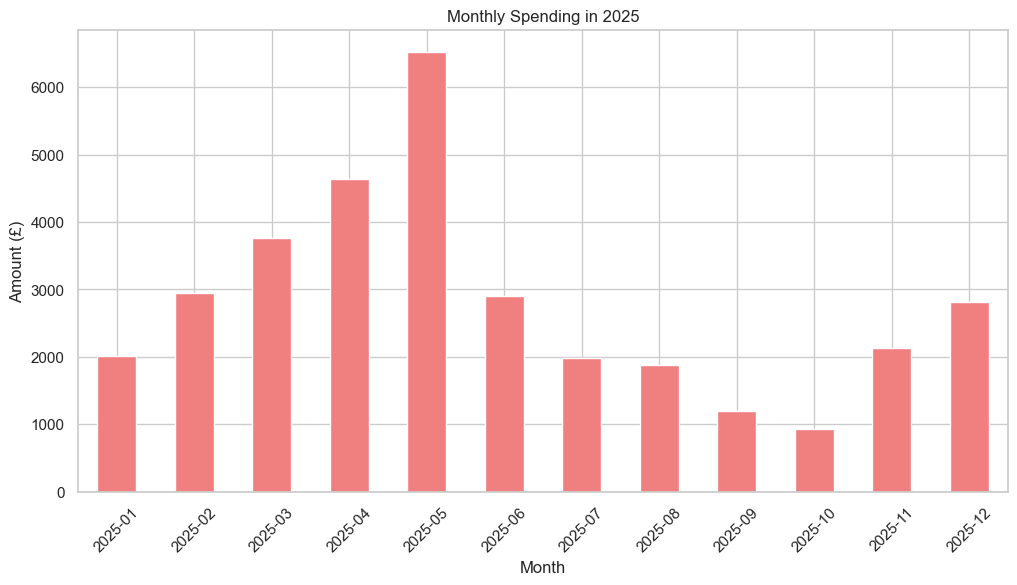

In [36]:
# Make sure 'date' is datetime
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')

# Filter only expenses
expenses = df[df['amount'] < 0].copy()
expenses['amount'] = expenses['amount'].abs()  # Make expenses positive for readability

# Extract month
expenses['month'] = expenses['date'].dt.to_period('M')

# Group by month and sum
monthly_summary = expenses.groupby('month')['amount'].sum()

# Display monthly totals
print(monthly_summary)

# Optional: Plot monthly spending
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
monthly_summary.plot(kind='bar', color='lightcoral')
plt.title("Monthly Spending in 2025")
plt.xlabel("Month")
plt.ylabel("Amount (£)")
plt.xticks(rotation=45)
plt.show()

Category vs Month

category    Bills  Eating out  Entertainment  Expenses  Family  Finances  \
month                                                                      
2025-01     80.00       90.27           0.00      0.00     0.0       0.0   
2025-02    292.94       84.61           0.00     38.00     0.0       0.0   
2025-03    239.83      125.82           0.00     25.00   485.0       0.0   
2025-04    135.92       87.05          24.33      0.00     0.0       0.0   
2025-05   3023.18      108.30           0.00      5.99     0.0     262.5   
2025-06     93.51       86.92           0.00      0.00     0.0       0.0   
2025-07     59.00        0.00          20.60      0.00     0.0       0.0   
2025-08    180.55      115.68           0.00      0.00     0.0       0.0   
2025-09     67.00       43.72           9.99     50.00     0.0       0.0   
2025-10    126.40       20.86           0.00      0.00     0.0       0.0   
2025-11     24.00        0.00           0.00      0.00     0.0       0.0   
2025-12     

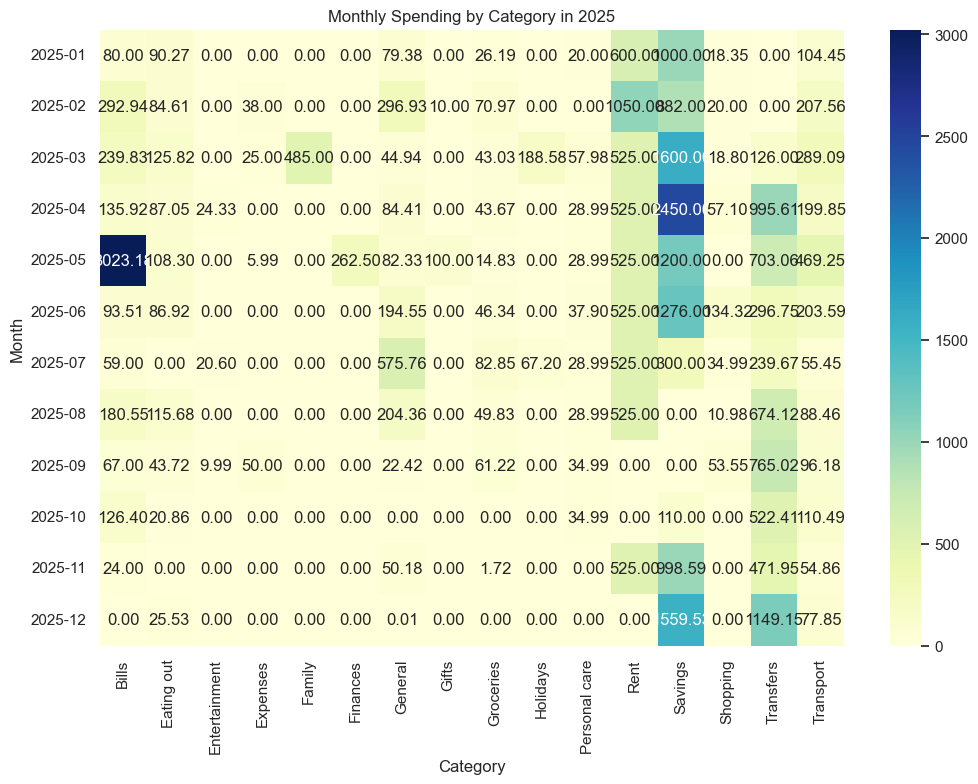

In [37]:
# Make sure we’re using expenses only
expenses = df[df['amount'] < 0].copy()
expenses['amount'] = expenses['amount'].abs()  # make positive for readability

# Extract month as period
expenses['month'] = expenses['date'].dt.to_period('M')

# Pivot table: rows = month, columns = category, values = sum of amount
category_monthly = expenses.pivot_table(index='month', columns='category', values='amount', aggfunc='sum', fill_value=0)

# Display the table
print(category_monthly)

# Optional: Heatmap visualization
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(category_monthly, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Monthly Spending by Category in 2025")
plt.xlabel("Category")
plt.ylabel("Month")
plt.show()


Insights & Summary

Top 3 Spending Categories in 2025:
category
Savings      11376.12
Transfers     5943.74
Rent          5325.00
Name: amount, dtype: float64

Month with highest spending: 2025-05 (£6,523.43)

Percentage of income spent in 2025: 100.01%


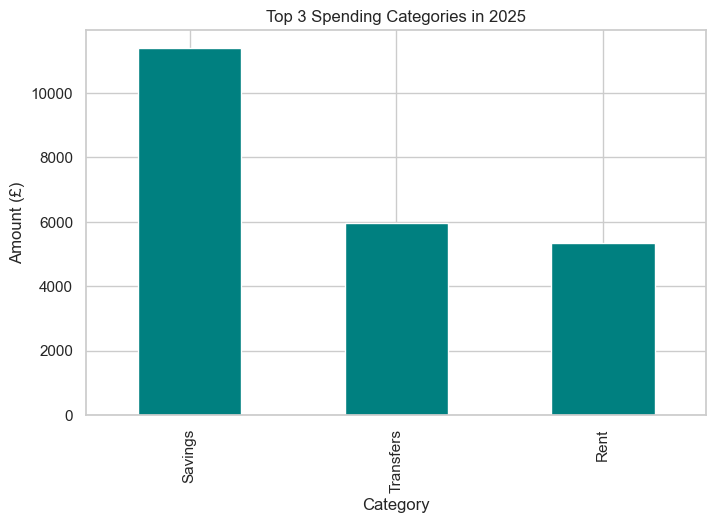

In [38]:
# 1️⃣ Top 3 spending categories
top_categories = expenses.groupby('category')['amount'].sum().sort_values(ascending=False).head(3)
print("Top 3 Spending Categories in 2025:")
print(top_categories)

# 2️⃣ Month with highest spending
monthly_total = expenses.groupby(expenses['date'].dt.to_period('M'))['amount'].sum()
max_month = monthly_total.idxmax()
max_amount = monthly_total.max()
print(f"\nMonth with highest spending: {max_month} (£{max_amount:,.2f})")

# 3️⃣ Percentage of income spent
total_income = df[df['amount'] > 0]['amount'].sum()
total_expenses = expenses['amount'].sum()
spent_percentage = (total_expenses / total_income) * 100
print(f"\nPercentage of income spent in 2025: {spent_percentage:.2f}%")

# 4️⃣ Optional: Plot top 3 categories
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
top_categories.plot(kind='bar', color='teal')
plt.title("Top 3 Spending Categories in 2025")
plt.ylabel("Amount (£)")
plt.xlabel("Category")
plt.show()


In [39]:
# 1️⃣ Identify unusually high spending per category (spikes)
category_avg = expenses.groupby('category')['amount'].mean()
category_std = expenses.groupby('category')['amount'].std()

# Flag any transaction > mean + 2*std as unusually high
expenses['spike'] = expenses.apply(
    lambda row: row['amount'] > category_avg.get(row['category'], 0) + 2*category_std.get(row['category'], 0),
    axis=1
)

spikes = expenses[expenses['spike']]
print("Unusually high spending transactions:")
print(spikes[['date', 'category', 'amount', 'name']])

# 2️⃣ Suggest areas to save (categories with highest avg spending)
top_saving_candidates = category_avg.sort_values(ascending=False).head(3)
print("\nCategories you could consider saving on:")
print(top_saving_candidates)

# 3️⃣ Optional: Quick text insights summary
total_expenses = expenses['amount'].sum()
total_income = df[df['amount'] > 0]['amount'].sum()
balance = total_income - total_expenses

summary = f"""
📝 Summary of 2025 Spending:

- Total Income: £{total_income:,.2f}
- Total Expenses: £{total_expenses:,.2f}
- Balance: £{balance:,.2f}
- Top 3 Spending Categories: {', '.join(top_categories.index.tolist())}
- Month with highest spending: {monthly_total.idxmax()} (£{monthly_total.max():,.2f})
- Suggested saving areas: {', '.join(top_saving_candidates.index.tolist())}
"""

print(summary)

Unusually high spending transactions:
           date    category   amount                           name
36   2025-01-17   Transport    24.60               National Express
41   2025-01-18   Transport    19.00                     Stagecoach
100  2025-02-10   Transport    36.00                     London Eye
111  2025-02-13   Groceries    40.49                        Groupon
161  2025-02-27        Rent  1050.00                 Atharv Yenpure
249  2025-03-14   Transport    21.74                           Uber
270  2025-03-20   Transport    31.70  London Bridge Railway Station
300  2025-03-28     Savings  1200.00                    Holiday Pot
347  2025-04-07   Transport    18.72                           Uber
429  2025-04-30     Savings  1750.00                        CCT Pot
432  2025-04-30   Transfers   500.00                    Sahil Dhage
482  2025-05-07   Transport    18.80                           Uber
483  2025-05-07   Transport    19.79                           Uber
485  2025-